In [1]:
import scanpy as sc

In [2]:
adata = sc.read_h5ad('../../data/RREAE_5k_raw_integration_processed.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
adata.obs.cell_type_reduced

cell_id
aaadgfgj-1          Neurons
aaaeckib-1          Neurons
aaaemkgl-1          Neurons
aaagfkdi-1          Neurons
aaagghkg-1          Neurons
                  ...      
oigfmhia-1     Unclassified
oiggakak-1      Endothelial
oignaocf-1      Endothelial
oigndfjg-1    Schwann cells
oigpcnmo-1    Schwann cells
Name: cell_type_reduced, Length: 891821, dtype: object

In [18]:
tier2_map = {
    "Neurons": "Neurons",
    "T cells": "T cells",
    "B cells": "B cells",
    "APCs": "APC/DC",
    "Dendritic cells": "APC/DC",

    "Macrophages": "Macrophages/Myeloid",
    "Myeloid cells": "Macrophages/Myeloid",
    "Efflux Mic_Mac": "Macrophages/Myeloid",
    "Foamy Mic_Mac": "Macrophages/Myeloid",
    "Activate Mic_Mac 1": "Macrophages/Myeloid",
    "Activated Mic_Mac 2": "Macrophages/Myeloid",

    "Microglia": "Microglia",
    "Proliferating microglia": "Proliferating microglia",

    "Astrocytes": "Astrocytes",
    "Astrocyte": "Astrocytes",
    "DA astrocytes": "Astrocytes",
    "Mic_AST": "Mic_AST",  # mixed microglia–astro signature → keep under DA astrocytes

    "Oligodendrocytes": "Oligodendrocytes",
    "DA oligodendrocytes": "Oligodendrocytes",
    "DA Oligodendrocytes": "Oligodendrocytes",
    "Newly formed oligodendrocytes": "Newly formed oligodendrocytes",
    "OPCs": "OPCs",
    "Schwann cells": "Schwann cells",

    "Endothelial cells": "Endothelial",
    "Vascular cells": "Endothelial",

    "Fibroblasts": "Stromal",
    "Stromal cells": "Stromal",

    "Ependymal cells": "Ependymal",
    "unclear": "Unclassified",
}
adata.obs['cell_type_reduced'] = adata.obs['cell_type'].map(tier2_map).fillna("Unclassified")

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_99219/243085556.py:175: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(M, aspect="equal", cmap=cmap, norm=norm, interpolation="nearest")
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_99219/243085556.py:175: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(M, aspect="equal", cmap=cmap, norm=norm, interpolation="nearest")
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_99219/243085556.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


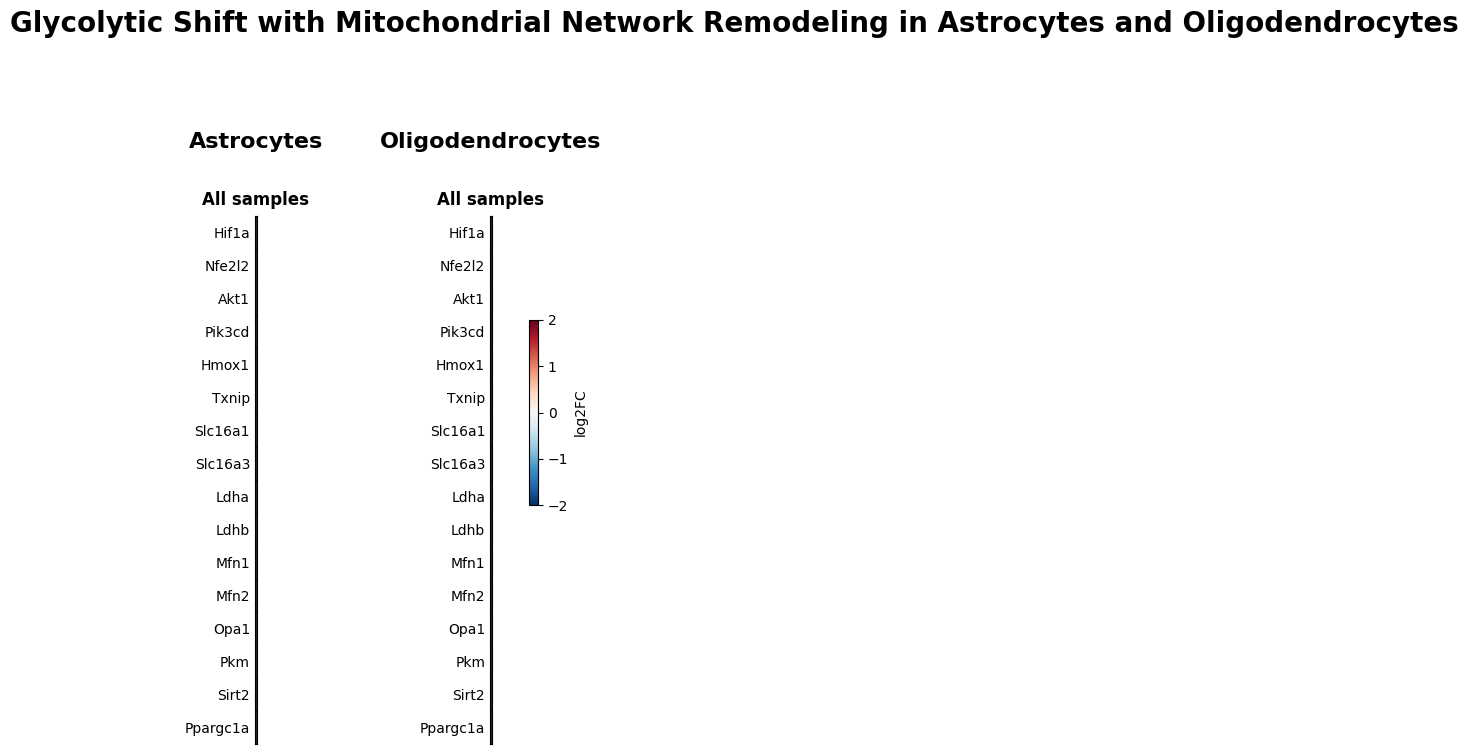

In [19]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# -------------------------
# 1) Select matrix (counts)
# -------------------------
def _get_counts(adata, layer="raw"):
    if layer is not None and layer in adata.layers:
        X = adata.layers[layer]
    else:
        X = adata.X
    return X

# CPM from pseudobulk counts
def _cpm(counts, axis=1):
    # counts: 1D or 2D array
    counts = counts.astype(float)
    lib = counts.sum(axis=axis, keepdims=True)
    lib[lib == 0] = 1.0
    return (counts / lib) * 1e6

# --------------------------------------------
# 2) Pseudobulk per (celltype, course, [model], condition)
# --------------------------------------------
def make_log2fc_from_adata(
    adata,
    celltype_col="cell_type_reduced",
    course_col="course",
    condition_col="condition",
    model_col="model",           # optional; ignored if not in obs
    case="EAE",
    control="CONTROL",
):
    X = _get_counts(adata, layer="raw")
    if sp.issparse(X):
        X = X.tocsr()
    var_names = np.array(adata.var_names)

    obs = adata.obs.copy()
    has_model = model_col in obs.columns

    group_cols = [celltype_col, course_col, condition_col]
    if has_model:
        group_cols.insert(2, model_col)  # celltype, course, model, condition

    # Build a DataFrame with groups and a row index mapping
    df_idx = pd.DataFrame({
        "row": np.arange(adata.n_obs),
        "celltype": obs[celltype_col].astype(str).values,
        "course": obs[course_col].astype(str).values,
        "condition": obs[condition_col].astype(str).values
    })
    if has_model:
        df_idx["model"] = obs[model_col].astype(str).values

    # Get unique groups
    by_cols = ["celltype", "course", "condition"] if not has_model else ["celltype","course","model","condition"]
    groups = df_idx.groupby(by_cols)["row"].apply(list).reset_index()

    # Pseudobulk counts (sum over cells) per group -> shape (n_groups, n_genes)
    ps_counts = []
    for rows in groups["row"]:
        if sp.issparse(adata.X):
            sub = X[rows, :]
            ps_counts.append(np.asarray(sub.sum(axis=0)).ravel())
        else:
            ps_counts.append(X[rows, :].sum(axis=0))
    ps_counts = np.vstack(ps_counts)

    # CPM per pseudobulk
    ps_cpm = _cpm(ps_counts, axis=1)  # each row normalized

    # Build DataFrame
    cols = list(var_names)
    ps = pd.DataFrame(ps_cpm, columns=cols)
    for c in by_cols:
        ps[c] = groups[c].values

    # Split case/control and compute log2FC = log2((case+1)/(ctrl+1))
    idx_cols = ["celltype","course"] if not has_model else ["celltype","course","model"]

    case_df = ps[ps["condition"] == case].drop(columns=["condition"])
    ctrl_df = ps[ps["condition"] == control].drop(columns=["condition"])

    # align by keys
    case_df = case_df.set_index(idx_cols).sort_index()
    ctrl_df = ctrl_df.set_index(idx_cols).sort_index()

    # keep only intersecting groups
    common_idx = case_df.index.intersection(ctrl_df.index)
    case_df = case_df.loc[common_idx]
    ctrl_df = ctrl_df.loc[common_idx]

    # log2FC matrix (n_groups x n_genes)
    l2fc_mat = np.log2((case_df.values + 1.0) / (ctrl_df.values + 1.0))

    l2fc = pd.DataFrame(l2fc_mat, index=common_idx, columns=cols).reset_index()

    # tidy long form
    log2fc_df = l2fc.melt(
        id_vars=idx_cols,
        var_name="gene",
        value_name="log2fc"
    )
    # add a 'model' column if absent (for plotting branch)
    if not has_model:
        log2fc_df["model"] = "All samples"

    return log2fc_df

# -------------------------
# 3) Build the figure
# -------------------------
def plot_multi_panel_heatmap(
    log2fc_df,
    genes,
    celltypes=("Astrocytes","Oligodendrocytes"),
    course_order_chronic=("non symptomatic","early onset","chronic peak","chronic long"),
    course_order_rr=("onset I","onset II","peak I","peak II","monophasic","remitt I","remitt II","peak III"),
    detect_models=("Chronic model","Relapse-remitting model"),
    vmax=2.0,
    title="Glycolytic Shift with Mitochondrial Network Remodeling in Astrocytes and Oligodendrocytes",
):
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
    cmap = plt.get_cmap("RdBu_r")

    # helper to order courses depending on model label
    def course_order_for(model_label):
        ml = model_label.lower()
        if "relapse" in ml or "remit" in ml:
            return list(course_order_rr)
        elif "chronic" in ml:
            return list(course_order_chronic)
        else:
            return sorted(log2fc_df["course"].unique())

    # ---- define panels ----
    panels = []
    for ct in celltypes:
        models_present = log2fc_df.query("celltype == @ct")["model"].unique().tolist()
        if len(models_present) >= 2:
            # keep desired order if possible
            ordered = [m for m in detect_models if m in models_present]
            for m in ordered:
                panels.append((ct, m))
        else:
            panels.append((ct, models_present[0] if models_present else "All samples"))

    # ---- figure layout ----
    n_panels = len(panels)
    fig, axes = plt.subplots(1, n_panels, figsize=(3*n_panels, 7), squeeze=False)
    axes = axes[0]

    for ax, panel in zip(axes, panels):
        if isinstance(panel, tuple):
            ct, model = panel
            d = log2fc_df.query("celltype == @ct and model == @model")
            stage_order = course_order_for(model)
            title_top = model
            super_title = ct
        else:
            ct = panel
            d = log2fc_df.query("celltype == @ct")
            stage_order = course_order_for("All samples")
            title_top = ""
            super_title = ct

        # Pivot to matrix
        M = d.pivot_table(index="gene", columns="course", values="log2fc", aggfunc="mean")
        M = M.reindex(index=genes, columns=stage_order).fillna(0.0).values

        im = ax.imshow(M, aspect="equal", cmap=cmap, norm=norm, interpolation="nearest")

        ax.set_xticks(np.arange(len(stage_order)))
        ax.set_xticklabels(stage_order, rotation=90, fontsize=9)
        ax.set_yticks(np.arange(len(genes)))
        ax.set_yticklabels(genes, fontsize=10)
        ax.tick_params(length=0)

        # grid lines for squares
        ax.set_xticks(np.arange(-0.5, M.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, M.shape[0], 1), minor=True)
        ax.grid(which="minor", color="black", linewidth=0.6)
        ax.tick_params(which="minor", length=0)

        if title_top:
            ax.set_title(title_top, fontsize=12, pad=8, fontweight="semibold")

        ax.text(0.5, 1.12, super_title, transform=ax.transAxes,
                ha="center", va="bottom", fontsize=16, fontweight="bold")

    # shared colorbar
    cbar = fig.colorbar(im, ax=axes, fraction=0.02, pad=0.02)
    cbar.set_label("log2FC", rotation=90)

    fig.suptitle(title, x=0.02, y=1.03, ha="left", va="bottom", fontsize=20, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
# -------------------------
# 4) Run it
# -------------------------
# gene list (edit to your set)
genes = [
    "Hif1a","Nfe2l2","Akt1","Pik3cd","Hmox1","Txnip","Slc16a1","Slc16a3",
    "Ldha","Ldhb","Mfn1","Mfn2","Opa1","Pkm","Sirt2","Ppargc1a"
]

log2fc_df = make_log2fc_from_adata(
    adata,
    celltype_col="cell_type_reduced",
    course_col="course",
    condition_col="condition",     # must contain 'EAE' and 'CONTROL'
    model_col="model" if "model" in adata.obs.columns else None
)

plot_multi_panel_heatmap(
    log2fc_df,
    genes=genes,
    celltypes=("Astrocytes","Oligodendrocytes"),
    # adjust course orders to your labels:
    course_order_chronic=("non symptomatic","early onset","chronic peak","chronic long"),
    course_order_rr=("onset I","onset II","peak I","peak II","monophasic","remitt","peak I","remitt II","peak III"),
    detect_models=("Chronic model","Relapse-remitting model"),
    vmax=2.0
)

In [20]:
adata.layers['raw']

<891821x5101 sparse matrix of type '<class 'numpy.float32'>'
	with 528065583 stored elements in Compressed Sparse Row format>

In [21]:
adata.obs.condition.unique()

['EAE', 'CONTROL']
Categories (2, object): ['CONTROL', 'EAE']

In [22]:
print("n_obs:", adata.n_obs)
print("cell_type_reduced uniques:", adata.obs['cell_type_reduced'].unique()[:10])
print("course uniques:", adata.obs['course'].unique()[:20])

cond = adata.obs['condition'].astype(str).str.strip()
print("condition value counts:\n", cond.value_counts(dropna=False))

if 'model' in adata.obs.columns:
    print("model value counts:\n", adata.obs['model'].astype(str).str.strip().value_counts(dropna=False))

n_obs: 891821
cell_type_reduced uniques: ['Neurons' 'T cells' 'APC/DC' 'B cells' 'Macrophages/Myeloid'
 'Endothelial' 'Oligodendrocytes' 'Stromal' 'Microglia' 'Astrocytes']
course uniques: ['remitt I', 'onset I', 'peak I', 'peak II', 'monophasic', ..., 'non symptomatic', 'early onset', 'chronic peak', 'chronic long', 'MOG CFA']
Length: 14
Categories (14, object): ['MOG CFA', 'PLP CFA', 'chronic long', 'chronic peak', ..., 'peak II', 'peak III', 'remitt I', 'remitt II']
condition value counts:
 condition
EAE        796387
CONTROL     95434
Name: count, dtype: int64
model value counts:
 model
RR         619519
Chronic    272302
Name: count, dtype: int64


In [26]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

# map your obs['model'] labels to the MODELS keys
MODEL_LABEL_TO_FAMILY = {"Chronic": "MOG", "RR": "PLP"}  # adjust if needed

def _get_counts(adata, layer="raw"):
    return adata.layers[layer] if layer in adata.layers else adata.X

def _pseudobulk_sum(X, idx):
    sub = X[idx, :]
    if sp.issparse(sub): 
        return np.asarray(sub.sum(axis=0)).ravel()
    return sub.sum(axis=0)

def _cpm(mat, axis=1):
    mat = mat.astype(float)
    lib = mat.sum(axis=axis, keepdims=True)
    lib[lib == 0] = 1.0
    return (mat / lib) * 1e6

def make_log2fc_vs_baseline(
    adata,
    MODELS,
    celltype_col="cell_type_reduced",
    course_col="course",
    condition_col="condition",
    model_col="model",
    case="EAE",
    control="CONTROL",
    layer="raw",
):
    # --- prep obs ---
    obs = adata.obs.copy()
    if model_col not in obs:
        raise KeyError(f"obs['{model_col}'] missing.")
    if condition_col not in obs:
        raise KeyError(f"obs['{condition_col}'] missing.")

    # normalize strings
    obs["_celltype"]  = obs[celltype_col].astype(str).str.strip()
    obs["_course"]    = obs[course_col].astype(str).str.strip()
    obs["_condition"] = obs[condition_col].astype(str).str.strip().str.upper()
    obs["_model_lbl"] = obs[model_col].astype(str).str.strip()

    # map model label -> family ("MOG" or "PLP")
    obs["_family"] = obs["_model_lbl"].map(MODEL_LABEL_TO_FAMILY)
    if obs["_family"].isna().any():
        unknown = sorted(obs.loc[obs["_family"].isna(), "_model_lbl"].unique())
        raise ValueError(f"Unmapped model labels in obs['{model_col}']: {unknown}. "
                         f"Edit MODEL_LABEL_TO_FAMILY.")

    X = _get_counts(adata, layer=layer)
    if sp.issparse(X): 
        X = X.tocsr()
    genes = np.array(adata.var_names)

    # index of rows by (celltype, family, course, condition)
    idx_df = pd.DataFrame({
        "row": np.arange(adata.n_obs),
        "celltype":  obs["_celltype"].values,
        "family":    obs["_family"].values,
        "course":    obs["_course"].values,
        "condition": obs["_condition"].values,
    })

    # build pseudobulks for all groups present
    groups = idx_df.groupby(["celltype","family","course","condition"])["row"].apply(list).reset_index()

    # pseudobulk CPM per group
    ps_counts = np.vstack([_pseudobulk_sum(X, rows) for rows in groups["row"]])
    ps_cpm = _cpm(ps_counts, axis=1)
    ps = pd.DataFrame(ps_cpm, columns=list(genes))
    ps = pd.concat([groups.drop(columns=["row"]), ps], axis=1)

    out_rows = []

    for family, spec in MODELS.items():
        baseline = spec["baseline"]            # e.g., "MOG CFA" or "PLP CFA"
        courses  = spec["courses"]             # ordered list for plotting

        # CONTROL baseline pseudobulk for this family (per celltype)
        ctrl_base = ps.query("family == @family and course == @baseline and condition == @control")
        if ctrl_base.empty:
            # allow slightly different casing in CONTROL
            ctrl_base = ps.query("family == @family and course == @baseline and condition.str.upper() == @control", engine='python')
        if ctrl_base.empty:
            raise ValueError(f"No CONTROL baseline found for family '{family}' at course '{baseline}'.")

        # make lookup: celltype -> baseline CPM vector
        base_lookup = {ct: ctrl_base.loc[ctrl_base["celltype"]==ct, genes].mean(axis=0).to_numpy()
                       for ct in ctrl_base["celltype"].unique()}

        # for each non-baseline course: compute EAE vs CONTROL-baseline log2FC
        eae_df = ps.query("family == @family and condition == @case and course != @baseline")
        if eae_df.empty:
            continue

        for (ct, crs), sub in eae_df.groupby(["celltype","course"]):
            case_vec = sub[genes].mean(axis=0).to_numpy()
            base_vec = base_lookup.get(ct, None)
            if base_vec is None:
                # if no baseline control for this ct, skip
                continue
            l2fc = np.log2((case_vec + 1.0) / (base_vec + 1.0))
            out_rows.append(pd.DataFrame({
                "celltype": ct,
                "model":    "Chronic model" if family=="MOG" else "Relapse-remitting model",
                "course":   crs,
                "gene":     genes,
                "log2fc":   l2fc
            }))

    if not out_rows:
        raise ValueError("No log2FC rows computed. Check MODELS, labels, or availability of baseline CONTROL.")

    log2fc_df = pd.concat(out_rows, ignore_index=True)
    return log2fc_df

In [28]:
MODELS = {'MOG': {'baseline': 'MOG CFA',
  'courses': ['non symptomatic',
   'early onset',
   'chronic peak',
   'chronic long']},
 'PLP': {'baseline': 'PLP CFA',
  'courses': ['onset I',
   'onset II',
   'peak I',
   'monophasic',
   'remitt I',
   'peak II',
   'remitt II',
   'peak III']}}

genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Serpina3n','Ppargc1a',"Mfn1","Mfn2","Opa1",'Sirt2']


In [29]:
log2fc_df = make_log2fc_vs_baseline(
    adata,
    MODELS=MODELS,
    celltype_col="cell_type_reduced",
    course_col="course",
    condition_col="condition",
    model_col="model",     # 'Chronic' / 'RR' in your data
    case="EAE",
    control="CONTROL",
    layer="raw"
)

# Quick sanity checks
print(log2fc_df.shape)
print(log2fc_df.groupby(["celltype","model"]).size().head())
print(sorted(log2fc_df.query("model=='Chronic model'")["course"].unique()))
print(sorted(log2fc_df.query("model=='Relapse-remitting model'")["course"].unique()))

(1040604, 5)
celltype    model                  
APC/DC      Chronic model              20404
            Relapse-remitting model    40808
Astrocytes  Chronic model              20404
            Relapse-remitting model    40808
B cells     Chronic model              20404
dtype: int64
['chronic long', 'chronic peak', 'early onset', 'non symptomatic']
['monophasic', 'onset I', 'onset II', 'peak I', 'peak II', 'peak III', 'remitt I', 'remitt II']


In [64]:
log2fc_df.celltype.unique()

array(['APC/DC', 'Astrocytes', 'B cells', 'Endothelial', 'Ependymal',
       'Macrophages/Myeloid', 'Mic_AST', 'Microglia', 'Neurons',
       'Newly formed oligodendrocytes', 'OPCs', 'Oligodendrocytes',
       'Proliferating microglia', 'Schwann cells', 'Stromal', 'T cells',
       'Unclassified'], dtype=object)

In [61]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np

def plot_with_models(log2fc_df, genes, MODELS):
    panels = [("Astrocytes","Chronic model"), ("Astrocytes","Relapse-remitting model"),
              ("Oligodendrocytes","Chronic model"), ("Oligodendrocytes","Relapse-remitting model")]

    fig, axes = plt.subplots(1, 4, figsize=(14, 5), constrained_layout=False)
    norm = TwoSlopeNorm(vmin = -1,vcenter=0)
    cmap = plt.get_cmap("RdBu_r")

    def course_order_for(model_label):
        fam = "MOG" if "Chronic" in model_label else "PLP"
        return MODELS[fam]["courses"]

    last_im = None
    for ax, (ct, mdl) in zip(axes, panels):
        d = log2fc_df.query("celltype == @ct and model == @mdl")
        if d.empty:
            ax.axis("off"); continue
        stages = course_order_for(mdl)
        M = d.pivot_table(index="gene", columns="course", values="log2fc", aggfunc="mean")
        M = M.reindex(index=genes, columns=stages).fillna(0.0).values

        last_im = ax.imshow(M, aspect="equal", cmap=cmap, norm=norm, interpolation="nearest")
        ax.set_xticks(np.arange(len(stages)))
        ax.set_xticklabels(stages, rotation=90, fontsize=9)
        ax.set_yticks(np.arange(len(genes)))
        ax.set_yticklabels(genes, fontsize=10, fontstyle="italic")
        ax.set_title(mdl, fontsize=11, pad=4, fontweight="semibold")

        # grid lines
        ax.set_xticks(np.arange(-0.5, len(stages), 1), minor=True)
        ax.set_yticks(np.arange(-0.5, len(genes), 1), minor=True)
        ax.grid(which="minor", color="black", linewidth=0.6)
        ax.tick_params(which="minor", length=0)

    # --- add group titles centered above pairs ---
    # Get positions of the first two axes (Astrocytes) and last two (Oligodendrocytes)
    astro_pos = [axes[0].get_position(), axes[1].get_position()]
    oligo_pos = [axes[2].get_position(), axes[3].get_position()]

    # x midpoint between the two panels
    astro_mid = (astro_pos[0].x0 + astro_pos[1].x1) / 2
    oligo_mid = (oligo_pos[0].x0 + oligo_pos[1].x1) / 2
    y_top = astro_pos[0].y1 + 0.1  # a little above axes

    fig.text(astro_mid, y_top, "Astrocytes", ha="center", va="bottom",
             fontsize=16, fontweight="bold")
    fig.text(oligo_mid, y_top, "Oligodendrocytes", ha="center", va="bottom",
             fontsize=16, fontweight="bold")

    if last_im is not None:
        cbar = fig.colorbar(last_im, ax=axes.ravel().tolist(), fraction=0.025, pad=0.18)
        cbar.set_label("log2FC vs CONTROL baseline", rotation=90)

    plt.subplots_adjust(left=0.10, right=0.82, wspace=0.25, bottom=0.15, top=0.88)
    plt.show()

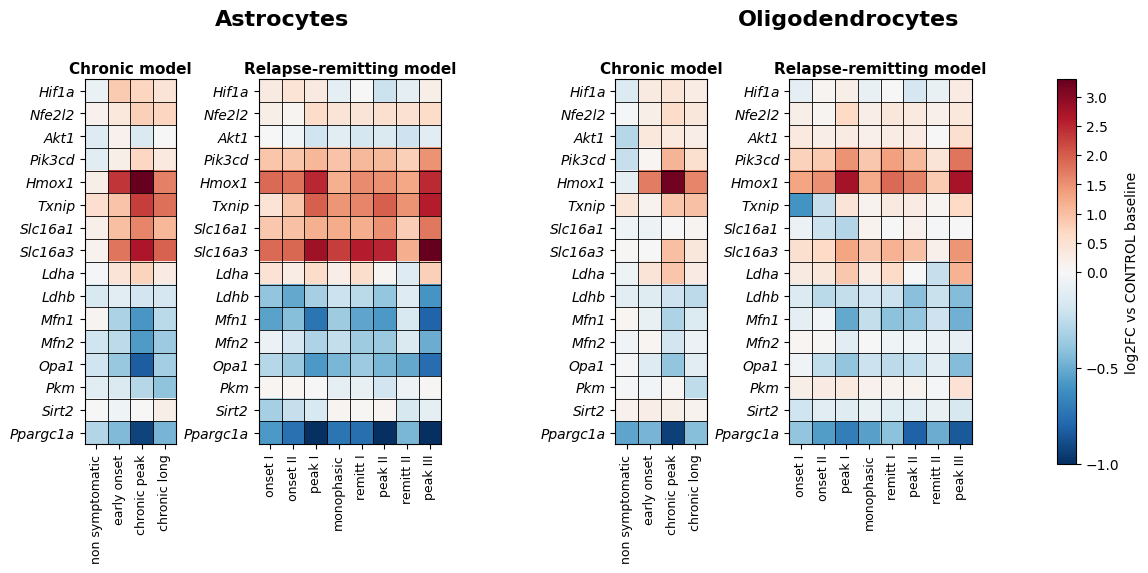

In [62]:
# Example genes (tweak as needed)
genes = ["Hif1a","Nfe2l2","Akt1","Pik3cd","Hmox1","Txnip","Slc16a1","Slc16a3",
         "Ldha","Ldhb","Mfn1","Mfn2","Opa1","Pkm","Sirt2","Ppargc1a"]

plot_with_models(log2fc_df, genes, MODELS)

In [83]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np

def plot_models_by_celltypes(log2fc_df, genes, MODELS,
                             celltypes=("Astrocytes","Oligodendrocytes"),
                             model_order=("Chronic model","Relapse-remitting model"),
                             vmax=None, cmap_name="RdBu_r",
                             fig_scale=(3.2, 5.0),  # width per panel, height
                             cbar_pad=0.18):
    """
    Draws 2 panels per cell type (Chronic + RR).
    Adds one centered title above each cell type pair.
    """
    # panels: [(ct, model), (ct, model), ...]
    panels = []
    for ct in celltypes:
        for mdl in model_order:
            panels.append((ct, mdl))

    n = len(panels)
    fig_w = fig_scale[0] * n
    fig_h = fig_scale[1]
    fig, axes = plt.subplots(1, n, figsize=(fig_w, fig_h), constrained_layout=False)

    norm = TwoSlopeNorm(vcenter=0) if vmax is None else TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    cmap = plt.get_cmap(cmap_name)

    def course_order_for(model_label):
        fam = "MOG" if "Chronic" in model_label else "PLP"
        return MODELS[fam]["courses"]

    last_im = None
    for ax, (ct, mdl) in zip(axes, panels):
        d = log2fc_df.query("celltype == @ct and model == @mdl")
        if d.empty:
            ax.axis("off")
            continue

        stages = course_order_for(mdl)
        M = d.pivot_table(index="gene", columns="course", values="log2fc", aggfunc="mean")
        M = M.reindex(index=genes, columns=stages).fillna(0.0).values

        last_im = ax.imshow(M, aspect="equal", cmap=cmap, norm=norm, interpolation="nearest")
        ax.set_xticks(np.arange(len(stages)))
        ax.set_xticklabels(stages, rotation=90, fontsize=9)
        ax.set_yticks(np.arange(len(genes)))
        ax.set_yticklabels(genes, fontsize=10, fontstyle="italic")
        ax.set_title(mdl, fontsize=11, pad=4, fontweight="semibold")

        # square gridlines
        ax.set_xticks(np.arange(-0.5, len(stages), 1), minor=True)
        ax.set_yticks(np.arange(-0.5, len(genes), 1), minor=True)
        ax.grid(which="minor", color="black", linewidth=0.6)
        ax.tick_params(which="minor", length=0)

    # ----- center a title above each cell-type pair -----
    # compute midpoints for each consecutive pair of axes
    for i, ct in enumerate(celltypes):
        a0 = axes[2*i].get_position()
        a1 = axes[2*i+1].get_position()
        mid_x = (a0.x0 + a1.x1) / 2.0
        y_top = a0.y1 + 0.1
        fig.text(mid_x, y_top, ct, ha="center", va="bottom",
                 fontsize=16, fontweight="bold")

    # colorbar, pushed outward
    if last_im is not None:
        cbar = fig.colorbar(last_im, ax=axes.ravel().tolist(), fraction=0.025, pad=cbar_pad)
        cbar.set_label("log2FC vs CONTROL baseline", rotation=90)

    # tighten spacing (adjust right to leave room for cbar)
    plt.subplots_adjust(left=0.0001, right=0.82, wspace=0.25, bottom=0.15, top=0.88)
    plt.show()

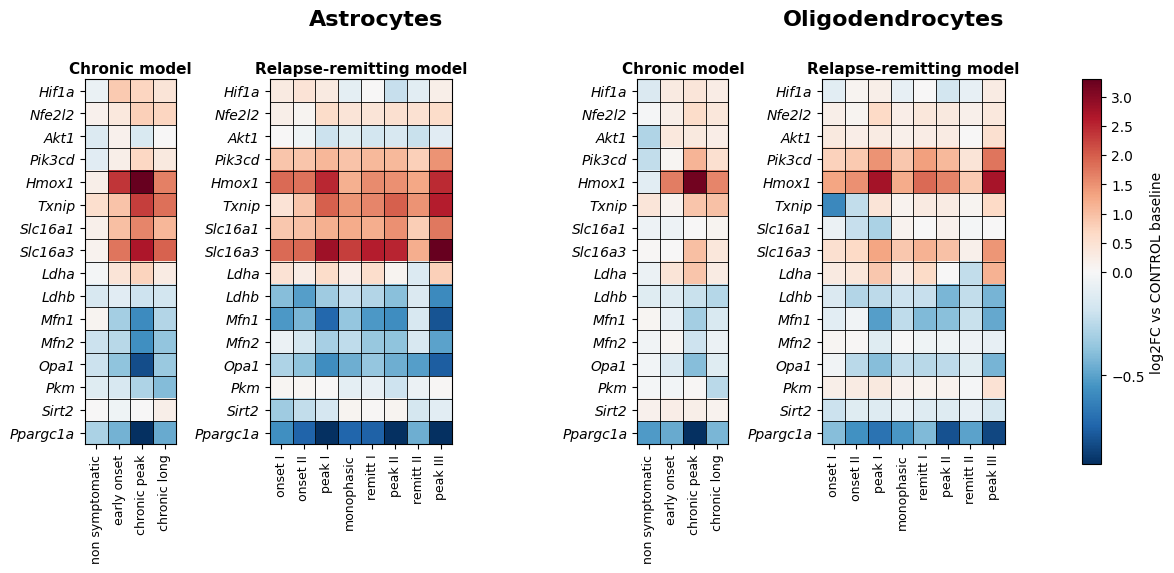

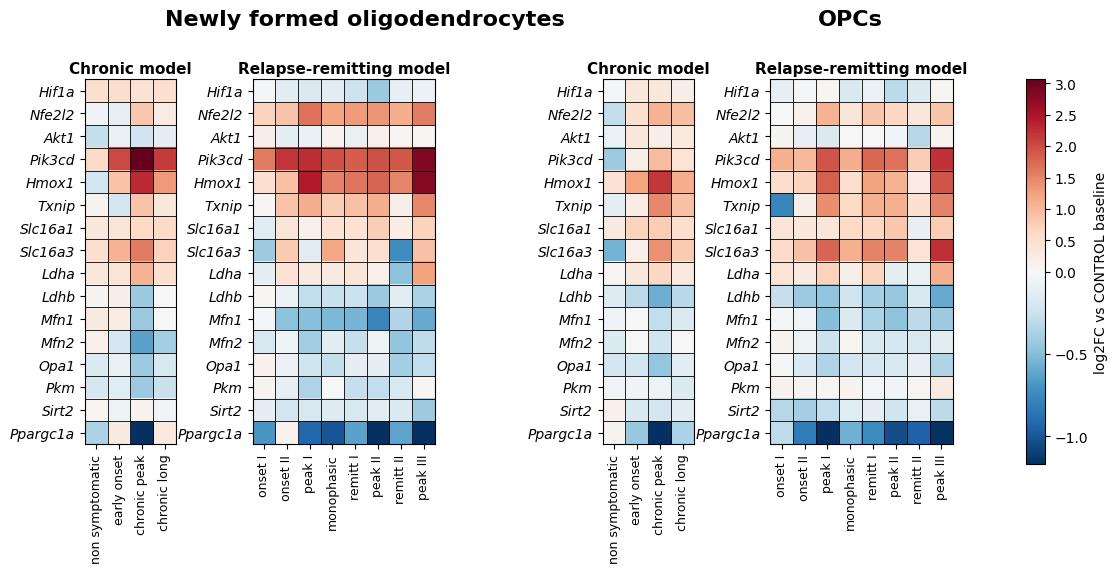

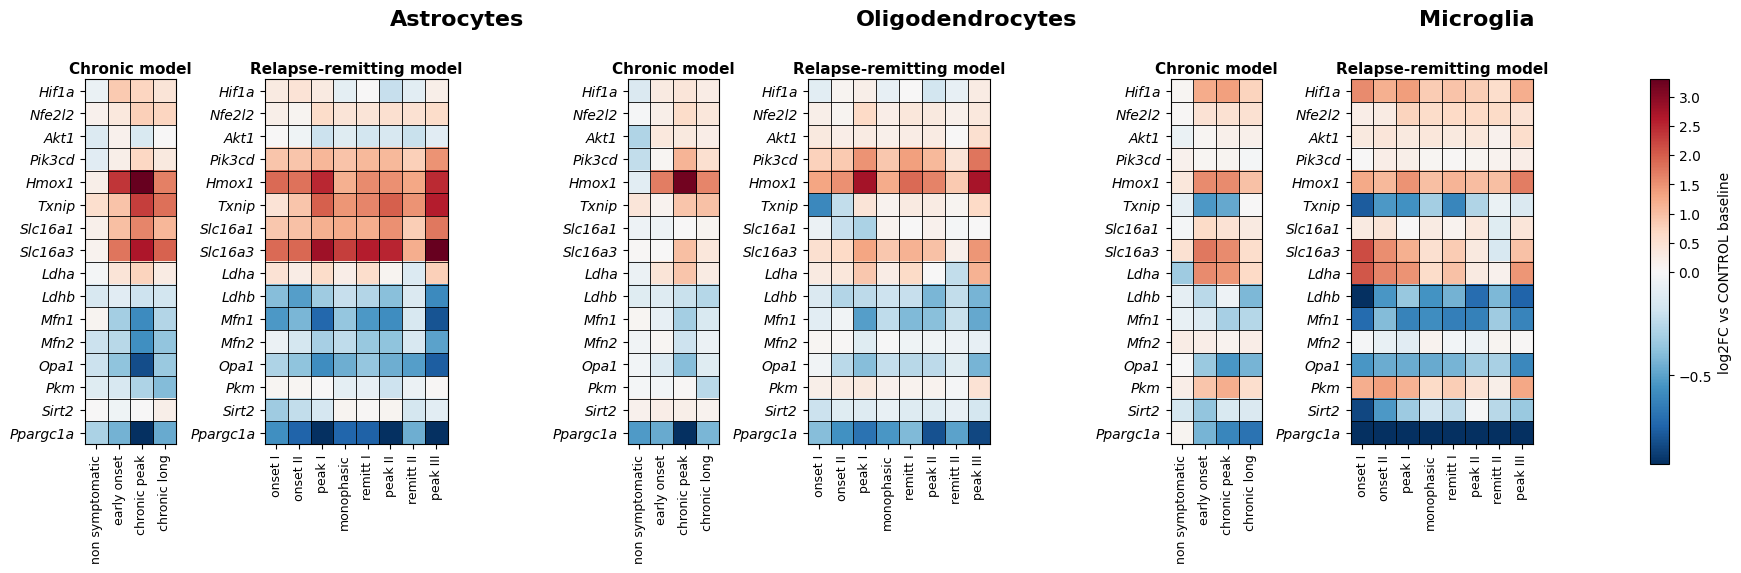

In [91]:
genes = ["Hif1a","Nfe2l2","Akt1","Pik3cd","Hmox1","Txnip","Slc16a1","Slc16a3",
         "Ldha","Ldhb","Mfn1","Mfn2","Opa1","Pkm","Sirt2","Ppargc1a"]

# Same as before (Astro + Oligo)
plot_models_by_celltypes(log2fc_df, genes, MODELS,
                         celltypes=("Astrocytes","Oligodendrocytes"))

# Any other types, e.g., Microglia + Endothelial + Neurons
plot_models_by_celltypes(log2fc_df, genes, MODELS,
                         celltypes=("Newly formed oligodendrocytes","OPCs"),
                         fig_scale=(3.0, 5.0), cbar_pad=0.5)

# If you want a fixed symmetric scale, e.g., ±2
plot_models_by_celltypes(log2fc_df, genes, MODELS,
                         celltypes=("Astrocytes","Oligodendrocytes","Microglia"),
                         cbar_pad=0.001)

In [86]:
adata_sub = adata[adata.obs.cell_type_reduced == 'Newly formed oligodendrocytes']

In [89]:
adata_sub.obs.course.value_counts()

course
peak II            1670
peak I             1548
peak III           1489
remitt I           1471
monophasic         1326
chronic peak       1083
chronic long        546
onset II            278
PLP CFA             267
early onset         249
onset I             190
remitt II           141
non symptomatic     125
MOG CFA             106
Name: count, dtype: int64

In [92]:
adata_sub

,x_centroid,y_centroid,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,...,sub_type_II,sub_type_III,cell_id_2,match_key,lesion_density_call,lesion_distance_um,lesion_distance_bin,celltype_merged,dist_bin,cell_type_reduced
cell_id,,,,,,,,,,,,,,,,,,,,,
aaadgfgj-1,181.586823,1630.103394,474,0,0,0,3,0,474.0,48.317189,...,Neuron II,Neuron,S1-B1_aaadgfgj-1,S1-B1|aaadgfgj-1,non_lesion,73.553208,50–100µm,Neuron,50–100µm,Neurons
aaaeckib-1,212.154877,1685.950928,882,0,0,0,1,0,882.0,46.194845,...,Neuron I,Neuron,S1-B1_aaaeckib-1,S1-B1|aaaeckib-1,non_lesion,91.839631,50–100µm,Neuron,50–100µm,Neurons
aaaemkgl-1,235.259537,1613.899048,1561,0,0,1,6,1,1561.0,112.800317,...,Neuron II,Neuron,S1-B1_aaaemkgl-1,S1-B1|aaaemkgl-1,non_lesion,128.016902,100–200µm,Neuron,100–200µm,Neurons
aaagfkdi-1,213.706497,1525.154907,1403,0,1,0,3,1,1403.0,71.708128,...,Neuron II,Neuron,S1-B1_aaagfkdi-1,S1-B1|aaagfkdi-1,non_lesion,126.550557,100–200µm,Neuron,100–200µm,Neurons
aaagghkg-1,196.850647,1526.920288,785,0,0,0,1,0,785.0,33.235001,...,Neuron I,Neuron,S1-B1_aaagghkg-1,S1-B1|aaagghkg-1,non_lesion,138.482463,100–200µm,Neuron,100–200µm,Neurons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oigfmhia-1,977.967346,1466.099365,1342,0,0,0,2,0,1342.0,140.752036,...,Neuron III,Neuron,G4_L1_oigfmhia-1,G4_L1|oigfmhia-1,non_lesion,1487.624504,>500µm,Neuron,>500µm,Unclassified
oiggakak-1,990.146912,1575.026855,404,0,0,0,0,0,404.0,40.008439,...,Pericyte I,Pericyte,G4_L1_oiggakak-1,G4_L1|oiggakak-1,non_lesion,1557.631619,>500µm,Pericyte,>500µm,Endothelial
oignaocf-1,946.469543,1601.946167,316,0,0,0,0,0,316.0,27.229220,...,Glial-like I,Glial-like,G4_L1_oignaocf-1,G4_L1|oignaocf-1,non_lesion,1607.066651,>500µm,Glial-like,>500µm,Endothelial
